In [ ]:
import random
import string
from typing import Annotated, List, TypedDict

from langchain.tools import tool
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate, SystemMessagePromptTemplate
from langchain_core.messages import SystemMessage, ToolMessage, HumanMessage

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode

The following code shows an extended example of building a custom LLM-based assistant. The target LLM is a 7B 6-bit-quantized Qwen2.5-7B-Instruct-1M-Q6_K (better for longer context) deployed on local LangCPP server. The main goal is to achieve complex behaviors by just using a local LLM, which can fit inside a notebook GPU (at most 8 GB memory). We would like to extend previous simple tool-agent by adding more structured reasoning capabilities to the cognitive architecture.

In [ ]:
llm = ChatOpenAI(
    base_url="http://localhost:8000/v1",
    api_key="sk-fake-key",  # Not needed but required for OpenAI compatibility,
    temperature=0.
)

response = llm.invoke("What is the capital of france?")
print(response.content)

The capital of France is Paris.


Let's use a custom LangGraph agent for the assistant. Our selected task for the bot is a filesystem assistant, where the AI can observe some local files and folder and decide to write some contents (attention: not safe for the systen, just for demonstration purpose). Let's implement some tools for the task, and check some basic queries:

In [ ]:
import os
import subprocess
from typing import List
from pathlib import Path
from langchain.tools import tool

WS_PATH = "workspace"

@tool
def list_directory(path: str) -> List[str]:
    """List the name of the child nodes inside a directory given its path."""
    try:
        if path[0] == '/':
            path = path[1:]
        return os.listdir(os.path.join(WS_PATH, path))
    except Exception as e:
        return [f"Error: {str(e)}, {os.path.join(WS_PATH, path)}"]

@tool
def read_file(path: str) -> str:
    """Read the content of a file given its path."""
    if path[0] == '/':
        path = path[1:]
    filepath = os.path.join(WS_PATH, path)
    if not os.path.exists(filepath):
        return "Error: File does not exist"
    try:
        with open(filepath, "r", encoding="utf-8") as file:
            return file.read()
    except Exception as e:
        return f"Error: {str(e)}, {os.path.join(WS_PATH, path)}"

@tool
def write_file(path: str, content: str) -> str:
    """Write some new content into a file given its path."""
    if path[0] == '/':
        path = path[1:]
    filepath = os.path.join(WS_PATH, path)
    try:
        print(f"Writing to {filepath}")
        with open(filepath, "w", encoding="utf-8") as file:
            file.write(content)
        return "Success: File updated."
    except Exception as e:
        return f"Error: {str(e)}, {os.path.join(WS_PATH, path)}"

@tool
def execute_main(path: str) -> str:
    """Execute a Python file given its path."""
    if path[0] == '/':
        path = path[1:]
    filepath = os.path.join(WS_PATH, path)
    if not os.path.exists(filepath):
        return "Error: File does not exist."
    try:
        result = subprocess.run(["python", filepath], capture_output=True, text=True)
        print("Executed Python main")
        return result.stdout if result.returncode == 0 else result.stderr
    except Exception as e:
        return f"Error: {str(e)}, {os.path.join(WS_PATH, path)}"

tools = [list_directory, read_file, write_file, execute_main]
tool_node = ToolNode(tools)

llm_with_tools = llm.bind_tools(tools)

In [ ]:
tools_description = None

for t in tools:
    curr_descr = f"- {t.name}("
    props_schema = t.args_schema.model_json_schema()['properties']
    for i,key_values in enumerate(t.args_schema.model_json_schema()['properties'].items()):
        k,v = key_values
        if not k == 'required':
            if len(props_schema.keys())> 1 and i == len(props_schema.keys())-1:
                curr_descr += f", {k.lower()}: {v['type']}"
            else:
                curr_descr += f"{k.lower()}: {v['type']}"
    
    curr_descr += f") -> {t.description.lower()}"

    if tools_description is None:
        tools_description = curr_descr
    else:
        tools_description = f"{tools_description}\n{curr_descr}"

print(tools_description)

- list_directory(path: string) -> list the name of the child nodes inside a directory given its path.
- read_file(path: string) -> read the content of a file given its path.
- write_file(path: string, content: string) -> write some new content into a file given its path.
- execute_main(path: string) -> execute a python file given its path.


The new baseline architecture we will test is a planner-based architecture, where the agent tries to make a plan based on the user query, and then it follows the plan until it completes. The new model also improves the simple tool-agent by defining a confirmation step w.r.t. user intent, and the possibility of replanning. Let's build the graph for the flow:

In [ ]:
def increase_num_calls(prev, val):
    if val:
        prev += val
    return prev

class CustomState(TypedDict):
    messages: Annotated[list, add_messages]
    num_tool_calls: Annotated[int, increase_num_calls]

In [ ]:
def call_llm(state: CustomState):
    messages = state["messages"]
    response = llm.invoke(messages)
    return {
        "messages": [response]
    }

In [ ]:
pmpt_plan = SystemMessagePromptTemplate.from_template("""
You are an assistant with no prior knowledge, you will eventually exploit some tools.
These are brief descriptions of the available tools:
{tools_description}

Describe very shortly, in prescriptive-style natural language, how to achieve the user goal using tools. You must never describe a step which refers to multiple calls (at most 1), in case break it down in multiple steps.Write just the steps, no other notes.


This is an example of an output step which must be avoided, and then the correct steps breaked down:
                                                      
1- Get all the producers of all the products which has tag equals to 'best seller'.         | NOT GOOD

1- Get the products which has tag equals to 'best seller'.                                  | GOOD
2- Get all producers of the products fetched at step 1.


This is generic example of the formatted output (add PLAN header):

PLAN:
1- Get all the cities belonging to the country 'France'
2- Get all the flights which starts from any of the cities obtained in step 1.
3- Filter the train lines obtained in step 2 by destination equals to 'Milan'.
4- Get all the flights which starts from 'Turin' and ends to 'Milan'.
5- Compute the output as the union of flights computed in step 3 plus the flights fetched in step 4.
""")


def call_plan(state: CustomState):
    messages = state["messages"]
    
    sys_msg = pmpt_plan.format(
        tools_description=tools_description
    )
    hmn_msg = HumanMessage(content=messages[0].content)
    response = llm.invoke([
        sys_msg, hmn_msg
    ])
    
    return {
        "messages": [response],
        "num_tool_calls": - state["num_tool_calls"]
    }

In [ ]:
CALL_CYCLE = 5

def call_tool(state: CustomState):
    if state['num_tool_calls'] < CALL_CYCLE:
        old_messages = state["messages"]
        messages = [
            SystemMessage(content="You have no prior domain knowledge. Always use your tools to answer the user query."),
        ]
        for m in old_messages[1:]:
            messages.append(m)
        messages[1] = HumanMessage(content=messages[1].content)
        response = llm_with_tools.invoke(messages)
        if hasattr(response, "tool_calls"):
            for tc in response.tool_calls:
                tc['id'] = gen_rand_id(8)
    
        return {
            "messages": [response],
            "num_tool_calls": 1
        }
    else:
        return {}

def gen_rand_id(length):
    letters = string.ascii_letters + string.digits
    return ''.join(random.choice(letters) for _ in range(length))

def route_tools(state: CustomState):
    messages = state["messages"]
    last_message = messages[-1]
    if hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0 and state['num_tool_calls'] <= CALL_CYCLE:
       state['num_tool_calls'] += 1  # Update the state properly
       return "tools"
    return "confirm"

In [ ]:
pmpt_confirm = SystemMessagePromptTemplate.from_template("""
You are an AI agent with no prior knowledge, but you have some tools.

The user will give you a first prompt, then after some time he will ask if you have enough informations to answer the first prompt. If some steps of your plan are still missing, you need to output KO.
You must output just one of 'OK' or 'KO' plus short explanations (no next steps). Examples of the formatted output:
- OK, I just acknowledged that the 'capital of Nowhere' being requested is 'NowhereCity'.
- KO, I just acknowledged which are the 'cheapest products' but I still don't know the required 'cheapest producers'.
- OK, I acknowledged that the requested 'best match in history' is referring to football for which we know the best match is 'Brazil-Germany'.
- OK, as required the book 'how to cook' has been purchased, and following the book 'how to clean kitchen' has been purchased as requested.
- KO, as required the 'shortest trip to Rome' has been purchased, but the required 'booking of hotel in Rome' to be performed next is still missing.
- KO, I just 'sent the email and waited the answer' as requested, but I still need to 'copy the answer in notepad' as requested next.
""")


def call_confirm(state: CustomState):
    messages = state["messages"]
    sys_msg = pmpt_confirm.format(
        last_state= messages[-1].content
    )
    hmn_msg = HumanMessage("Now you know the answer of my first question?")
    invoke_msgs = []
    pass_msg = False
    for i,m in enumerate(messages):
        if pass_msg:
            pass_msg = False
            continue
        if isinstance(m, ToolMessage):
            pass_msg = True
        invoke_msgs.append(m)

    response = llm.invoke([
        sys_msg, *messages, hmn_msg
    ])
    
    return {
        "messages": [response]
    }

def route_confirm(state: CustomState):
    messages = state["messages"]
    last_message = messages[-1]

    if 'KO' in last_message.content[:2]:
        return 'replan'
    return 'answer'

In [ ]:
pmpt_replan = SystemMessagePromptTemplate.from_template("""
You are an assistant with no prior knowledge, you will eventually exploit some tools.
These are brief descriptions of the available tools:
{tools_description}
""")


def call_replan(state: CustomState):
    messages = state["messages"]
    
    sys_msg = pmpt_replan.format(
        tools_description=tools_description
    )
    
    invoke_msgs = []
    pass_msg = False
    for i,m in enumerate(messages):
        if pass_msg:
            pass_msg = False
            continue
        if isinstance(m, ToolMessage):
            pass_msg = True
        invoke_msgs.append(m)

    hmn_msg = HumanMessage("Write the net plan to answer my first question, without the steps that you already performed, but keeping the ones which are still missing. Write just the steps and mantain the plan style, no other notes.")
    response = llm.invoke([
        sys_msg, *invoke_msgs, hmn_msg
    ])
    
    return {
        "messages": [response],
        "num_tool_calls": - state["num_tool_calls"]
    }

In [ ]:
pmpt_answer = SystemMessagePromptTemplate.from_template("""
You are an assistant with no prior knowledge.
These are brief descriptions of the available tools:
{tools_description}
""")


def call_answer(state: CustomState):
    messages = state["messages"]
    
    sys_msg = pmpt_answer.format(
        tools_description=tools_description
    )
    
    invoke_msgs = []
    pass_msg = False
    for i,m in enumerate(messages):
        if pass_msg:
            pass_msg = False
            continue
        if isinstance(m, ToolMessage):
            pass_msg = True
        invoke_msgs.append(m)

    hmn_msg = HumanMessage("Give me a summarized net answer to my original question.")
    response = llm.invoke([
        sys_msg, *invoke_msgs, hmn_msg
    ])
    
    return {
        "messages": [response]
    }

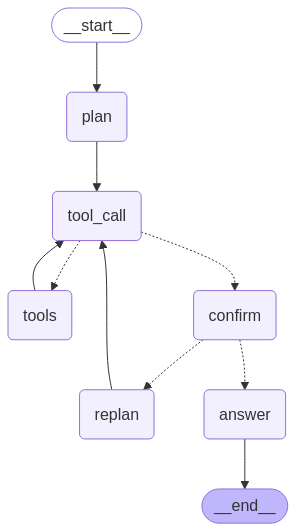

In [ ]:
workflow = StateGraph(CustomState)

workflow.add_node("plan", call_plan)
workflow.add_node("tool_call", call_tool)
workflow.add_node("tools", tool_node)
workflow.add_node("confirm", call_confirm)
workflow.add_node("replan", call_replan)
workflow.add_node("answer", call_answer)

workflow.add_edge(START, "plan")
workflow.add_edge("plan", "tool_call")
workflow.add_conditional_edges("tool_call", route_tools, ["tools", "confirm"])
workflow.add_edge("tools", "tool_call")
workflow.add_conditional_edges("confirm", route_confirm, ["replan", 'answer'])
workflow.add_edge("replan", "tool_call")
workflow.add_edge("answer", END)

app = workflow.compile()

from IPython.display import Image, display
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

Let's check the behavior for some user queries:

In [ ]:
for chunk in app.stream(
    {"messages": [
        ("human", "What is the content of one random file inside the directory at '/subdir'?")
    ]}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What is the content of one random file inside the directory at '/subdir'?
================================== Ai Message ==================================

PLAN:
1- List the child nodes inside the directory '/subdir'.
2- Select one random file from the list obtained in step 1.
3- Read the content of the file selected in step 2.
================================== Ai Message ==================================
Tool Calls:
  list_directory (zLqhHYvl)
 Call ID: zLqhHYvl
  Args:
    path: /subdir
================================= Tool Message =================================
Name: list_directory

["dummy2.txt", "dummy3.txt", "subdir2"]
================================== Ai Message ==================================
Tool Calls:
  read_file (UhgmgrtY)
 Call ID: UhgmgrtY
  Args:
    path: /subdir/dummy2.txt
================================= Tool Message =================================
Name: read_file

AAABDISFG

In [ ]:
for chunk in app.stream(
    {"messages": [
        ("human", "Can you write the content of 'dummy.txt' inside the file at 'subdir/dummy2.txt?'")
    ]}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Can you write the content of 'dummy.txt' inside the file at 'subdir/dummy2.txt?'
================================== Ai Message ==================================

PLAN:
1- Read the content of 'dummy.txt'.
2- Write the content read in step 1 into 'subdir/dummy2.txt'.
================================== Ai Message ==================================
Tool Calls:
  read_file (pmjbffYP)
 Call ID: pmjbffYP
  Args:
    path: dummy.txt
================================= Tool Message =================================
Name: read_file

Auisa&8sva72
================================== Ai Message ==================================
Tool Calls:
  write_file (f2YXX9Sb)
 Call ID: f2YXX9Sb
  Args:
    path: subdir/dummy2.txt
    content: Auisa&8sva72
Writing to workspace\subdir/dummy2.txt
================================= Tool Message =================================
Name: write_file

Success: File updated.
==================

In [ ]:
for chunk in app.stream(
    {"messages": [
        ("human", "Can you write the content of the file 'dummy.txt' inside the file 'subdir/dummy2.txt'? then write the content of the file 'subdir/dummy3.txt' into the file 'dummy.txt'")
    ]}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Can you write the content of the file 'dummy.txt' inside the file 'subdir/dummy2.txt'? then write the content of the file 'subdir/dummy3.txt' into the file 'dummy.txt'
================================== Ai Message ==================================

PLAN:
1- Read the content of the file 'dummy.txt'.
2- Write the content of step 1 into 'subdir/dummy2.txt'.
3- Read the content of the file 'subdir/dummy3.txt'.
4- Write the content of step 3 into 'dummy.txt'.
================================== Ai Message ==================================
Tool Calls:
  read_file (HOAC8jTm)
 Call ID: HOAC8jTm
  Args:
    path: dummy.txt
================================= Tool Message =================================
Name: read_file

Auisa&8sva72
================================== Ai Message ==================================
Tool Calls:
  write_file (f7RrYBGG)
 Call ID: f7RrYBGG
  Args:
    path: subdir/dummy2.txt
    content: